## Batch NomalizationとLayer Normalization

### ライブラリ

In [18]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from functools import partial
import torchvision
from torchvision import transforms
import utils

### hook

#### .register_hook

In [6]:
# tensorに対してhookを登録する
a = torch.ones(5, requires_grad=True)
b = 2 * a
b.retain_grad()
b.register_hook(lambda grad: print(grad))
c = b.mean()
c.backward()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


#### .register_forward_hook()

In [14]:
# moduleに対してhookを登録する
conv_model = nn.Sequential(
    # 1x28x28 -> 4x14x14
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14 -> 8x7x7
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7 -> 16x4x4
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4 -> 32x2x2
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    #nn.AdaptiveAvgPool2d(1),   # <- GAP
    # 32
    nn.Flatten(),
    # 10
    nn.Linear(128, 10)
)

# hookの登録状況を表示する関数
def print_hooks(model):
    for name, module in model.named_modules():
        if hasattr(module, '_forward_hooks'):
            for hook in module._forward_hooks.values():
                print(f'Module {name} has forward hook: {hook}')
        if hasattr(module, '_backward_hooks'):
            for hook in module._backward_hooks.values():
                print(f'Module {name} has backward hook: {hook}')

# hookに登録する関数
outputs = {}
def save_output(name, module, input, output):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = output.shape

# hook登録
for name, module in conv_model.named_modules():
    if name:
        module.register_forward_hook(partial(save_output, name))

# forwardでhook発動
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)

# hookの結果を表示
print_hooks(conv_model)

Module 0 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '0')
Module 1 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '1')
Module 2 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '2')
Module 3 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '3')
Module 4 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '4')
Module 5 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '5')
Module 6 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '6')
Module 7 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '7')
Module 8 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '8')
Module 9 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '9')


#### .register_full_backward_hook

In [15]:
grads = {}
# hookに登録する関数
def save_grad_in(name, module, grad_in, grad_out):
    module_name = f'{name}_{str(module)}'
    grads[module_name] = grad_in

# hook登録
for name, module in conv_model.named_modules():
    if name:
        module.register_full_backward_hook(partial(save_grad_in, name))

print_hooks(conv_model)

Module 0 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '0')
Module 0 has backward hook: functools.partial(<function save_grad_in at 0x7fe3d14c1700>, '0')
Module 1 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '1')
Module 1 has backward hook: functools.partial(<function save_grad_in at 0x7fe3d14c1700>, '1')
Module 2 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '2')
Module 2 has backward hook: functools.partial(<function save_grad_in at 0x7fe3d14c1700>, '2')
Module 3 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '3')
Module 3 has backward hook: functools.partial(<function save_grad_in at 0x7fe3d14c1700>, '3')
Module 4 has forward hook: functools.partial(<function save_output at 0x7fe3d147a430>, '4')
Module 4 has backward hook: functools.partial(<function save_grad_in at 0x7fe3d14c1700>, '4')
Module 5 has forward hook: functools.partial(<function save_output at 

### Activationの可視化

In [16]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
train_dataset = torchvision.datasets.FashionMNIST('~/tmp/fashion_mnist', download=True, train=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('~/tmp/fashion_mnist', download=True, train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

# model
conv_model = nn.Sequential(
    # 1x28x28 -> 4x14x14
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14 -> 8x7x7
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7 -> 16x3x3
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4 -> 32x1x1
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    #nn.AdaptiveAvgPool2d(1),   # <- GAP
    # 32
    nn.Flatten(),
    # 10
    nn.Linear(128, 10)
)

# optimizer
opt = optim.SGD(conv_model.parameters(), lr=0.6)

###################### フックの登録 ########################
# 保存するリストを作成
act_means = [[] for module in conv_model if isinstance(module, nn.ReLU)] # RELUの数だけリストを作成  [[mea1, std1], [mea2, std2], ...]
act_stds = [[] for module in conv_model if isinstance(module, nn.ReLU)]

# フックに登録する関数
def save_out_stats(i, module, input, output):
    act_means[i].append(output.mean().item())
    act_stds[i].append(output.std().item())

# フック登録
relu_layers = [module for module in conv_model if isinstance(module, nn.ReLU)]
for i, relu in enumerate(relu_layers):
    relu.register_forward_hook(partial(save_out_stats, i))

In [17]:
# 学習
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 2.2881610231884455, validation error: 2.2933701992034914, validation accuracy: 0.10013751611113549


epoch: 1: train error: 2.2535071554830517, validation error: 2.2796319007873533, validation accuracy: 0.10034877210855483


epoch: 2: train error: 1.690624755317882, validation error: 0.9425224959850311, validation accuracy: 0.6531269907951355


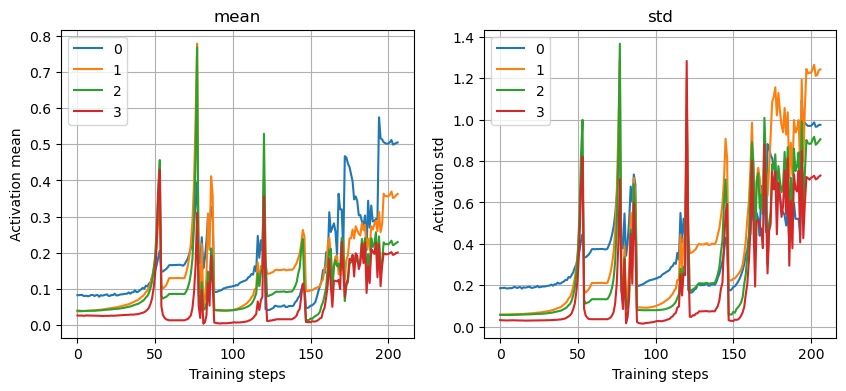

In [28]:
# activationの可視化
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for act_mean in act_means:
    ax[0].plot(act_mean)
    ax[0].set_title('mean')
    ax[0].set_xlabel('Training steps')
    ax[0].set_ylabel('Activation mean')
    ax[0].legend(range(len(act_means)))
    ax[0].grid(True)
for act_stds in act_stds:
    ax[1].plot(act_stds)
    ax[1].set_title('std')
    ax[1].set_xlabel('Training steps')
    ax[1].set_ylabel('Activation std')
    ax[1].legend(range(len(act_stds)))
    ax[1].grid(True)

In [ ]:
class ActivationStatistics:
    """
    activationを保存するクラス
    """
    def __init__(self, model):
        self.model = model
        self.act_means = [[] for module in model if isinstance(module, nn.ReLU)]
        self.act_stds = [[] for module in model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))
    
    def save_out_stats(self, i, module, input, output):
        self.act_means[i].append(output.detach().mean().item())
        self.act_stds[i].append(output.detach().std().item())
    
    def get_statistics(self):
        return self.act_means, self.act_stds
    
    def plot_statistics(self):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        for act_mean in self.act_means:
            ax[0].plot(act_mean)
            ax[0].set_title('mean')
            ax[0].set_xlabel('Training steps')
            ax[0].set_ylabel('Activation mean')
            ax[0].legend(range(len(act_means)))
            ax[0].grid(True)
        for act_std in self.act_stds:
            ax[1].plot(act_std)
            ax[1].set_title('std')
            ax[1].set_xlabel('Training steps')
            ax[1].set_ylabel('Activation std')
            ax[1].legend(range(len(act_std)))
            ax[1].grid(True)
        plt.show()

### Batch normalization

#### スクラッチで実装

In [30]:
def batch_norm(X, gamma, beta, eps=1e-5):
    mean = X.mean(dim=(0, 2, 3), keepdim=True)
    var = X.var(dim=(0, 2, 3), keepdim=True)
    X_norm = (X - mean) / torch.sqrt(var + eps)
    return gamma * X_norm + beta

#### Pytorchで実装

In [32]:
# データ準備
X , y = next(iter(train_loader))
# conv
conv_out = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)(X)
# batch norm
norm_out = nn.BatchNorm2d(8)(conv_out)
# 結果の表示
norm_out.mean(dim=(0, 2, 3)), norm_out.var(dim=(0, 2, 3))

(tensor([-3.1475e-08,  6.0583e-08,  2.1002e-08, -5.5499e-09,  2.6704e-08,
          3.4307e-08,  2.2827e-08, -7.1275e-09], grad_fn=<MeanBackward1>),
 tensor([1.0000, 0.9996, 0.9993, 1.0000, 0.9999, 0.9999, 0.9997, 1.0000],
        grad_fn=<VarBackward0>))

### Layer normalization

#### スクラッチで実装

In [34]:
def layer_norm(X, gamma, beta, eps=1e-5):
    mean = X.mean(dim=(1, 2, 3), keepdim=True)
    var = X.var(dim=(1, 2, 3), keepdim=True)
    X_norm = (X - mean) / torch.sqrt(var + eps)
    return gamma * X_norm + beta

#### Pytorchで実装

In [60]:
X , y = next(iter(train_loader))
conv_out = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)(X)
norm_out = nn.LayerNorm([8, 14, 14])(conv_out)